In [1]:
import json
from transformers import AutoTokenizer, AutoConfig
from tqdm import tqdm
import matplotlib.pyplot as plt
import math

In [2]:
PROMPT_DICT = {
    "prompt_no_input": (
        "Below is an instruction that describes a task. "
        "Write a response that appropriately completes the request.\n\n"
        "### Instruction:\n{instruction}\n\n### Response:"
    ),
    "prompt_no_input_llama2": (
        "<s>[INST] <<SYS>>\n"
        "You are a helpful, respectful and honest assistant. Always answer as helpfully as possible, while being safe.  Your answers should not include any harmful, unethical, racist, sexist, toxic, dangerous, or illegal content. Please ensure that your responses are socially unbiased and positive in nature.\n\n"
        "If a question does not make any sense, or is not factually coherent, explain why instead of answering something not correct. If you don't know the answer to a question, please don't share false information.\n"
        "<</SYS>> \n\n {instruction} [/INST]"
    ),
    "prompt_llama2": "[INST]{instruction}[/INST]"
}

In [3]:
prompt_no_input = PROMPT_DICT["prompt_llama2"]

In [4]:
question = "Summarize the meeting transcrip. Summarize each item in two sentences."

In [5]:
model_name = "Yukang/LongAlpaca-7B"
cache_dir = "../cache"
context_size = 32768

In [6]:
config = AutoConfig.from_pretrained(model_name, cache_dir=cache_dir)

In [7]:
orig_ctx_len = getattr(config, "max_position_embeddings", None)
if orig_ctx_len and context_size > orig_ctx_len:
    scaling_factor = float(math.ceil(context_size / orig_ctx_len))
    config.rope_scaling = {"type": "linear", "factor": scaling_factor}

In [8]:
tokenizer = AutoTokenizer.from_pretrained(
        model_name,
        cache_dir=cache_dir,
        model_max_length=context_size if context_size > orig_ctx_len else orig_ctx_len,
        padding_side="right",
        use_fast=False,
    )

In [9]:
def num_tokens_from_string(string):
    return len(tokenizer.encode(string))

In [10]:
def calculate_length(path):
    with open(path, 'r') as f:
        data = json.load(f)
    source_lengths = []
    target_lengths = []
    for meeting in tqdm(data):
        source_lengths.append(num_tokens_from_string(prompt_no_input.format_map({"instruction": meeting['source'] + "\n%s"%question})))
        target_lengths.append(num_tokens_from_string(meeting['summary']))
    return source_lengths, target_lengths

In [11]:
def min_max_avg(numbers):
    min_val = min(numbers)
    max_val = max(numbers)
    avg_val = sum(numbers) / len(numbers)
    return min_val, max_val, avg_val

In [12]:
def plot_lengths(source_lengths, target_lengths):
    plt.hist(source_lengths, bins=100, alpha=0.5, color='blue', label='Source')
    plt.hist(target_lengths, bins=100, alpha=0.5, color='red', label='Target')
    plt.show()

In [13]:
def helper(task):
    source_lengths, target_lengths = calculate_length(f'{task}_text.json')

    source_min, source_max, source_avg = min_max_avg(source_lengths)
    print(f'{task}-source: min={source_min}, max={source_max}, avg={source_avg}')

    target_min, target_max, target_avg = min_max_avg(target_lengths)
    print(f'{task}-target: min={target_min}, max={target_max}, avg={target_avg}')

    plot_lengths(source_lengths, target_lengths)

100%|██████████| 1266/1266 [02:12<00:00,  9.53it/s]


train-source: min=26, max=32102, avg=15273.567930489731
train-target: min=1, max=3058, avg=512.1437598736177


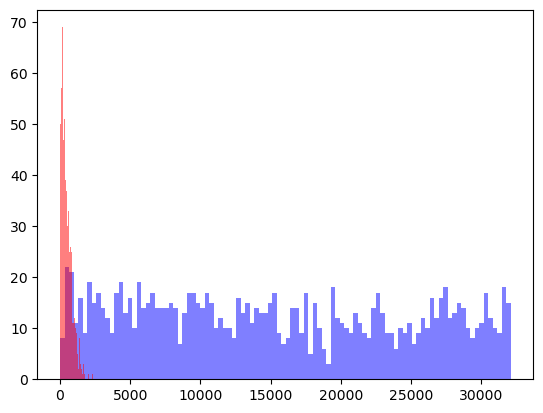

100%|██████████| 159/159 [00:18<00:00,  8.77it/s]


test-source: min=26, max=32046, avg=16779.64779874214
test-target: min=1, max=2850, avg=513.8427672955975


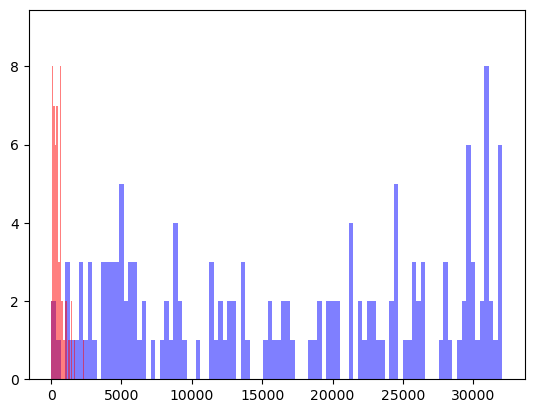

100%|██████████| 158/158 [00:17<00:00,  9.09it/s]


validation-source: min=360, max=32064, avg=16095.791139240506
validation-target: min=43, max=2383, avg=513.6518987341772


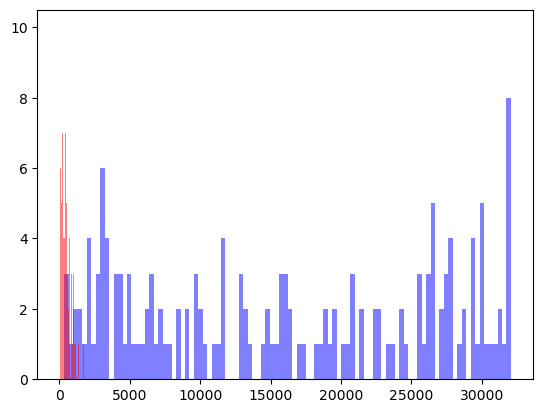

In [14]:
for task in ['train', 'test', 'validation']:
    helper(task)